# Incubator State Estimation with a Particle Filter

Next we contruct the kalman filter, using the system sympy library to transform the system symbolic equations to a discrete time system.
We adjust the equations from [ModellingIncubatorDynamics](../3-Physics-Modelling/2-ModellingIncubatorDynamics.ipynb).

In [1]:
import sympy as sp
import numpy as np

import sympy as sp
import numpy as np

# Parameters
C_air = sp.Symbol("C_air", real=True)  # Specific heat capacity
G_box = sp.Symbol("G_box", real=True)  # Specific heat capacity
C_heater = sp.Symbol("C_heater", real=True)  # Specific heat capacity
G_heater = sp.Symbol("G_heater", real=True)  # Specific heat capacity

# Constants
V_heater = sp.Symbol("V_heater", real=True)
i_heater = sp.Symbol("i_heater", real=True)

# Inputs
in_room_temperature = sp.Symbol("T_room", real=True)
on_heater = sp.Symbol("on_heater", real=True)

# States
T = sp.Symbol("T", real=True)
T_heater = sp.Symbol("T_heater", real=True)

power_in = on_heater * V_heater * i_heater

power_transfer_heat = G_heater * (T_heater - T)

total_power_heater = power_in - power_transfer_heat

power_out_box = G_box * (T - in_room_temperature)

total_power_box = power_transfer_heat - power_out_box

der_T_heater = (1.0 / C_heater) * (total_power_heater)
der_T = (1.0 / C_air) * (total_power_box)

# Vectorize der_T and der_T_heater so they can be applied to the particles
der_T_heater_function = sp.lambdify((T_heater, T, C_air, G_box, C_heater, G_heater, V_heater, i_heater, in_room_temperature, on_heater), der_T_heater)
der_T_function = sp.lambdify((T_heater, T, C_air, G_box, C_heater, G_heater, V_heater, i_heater, in_room_temperature, on_heater), der_T)

In [2]:
# System parameters
V_heater_num = HEATER_VOLTAGE = 12.0
i_heater_num = HEATER_CURRENT = 10.45
C_air_num = 68.21
G_box_num = 0.74 
C_heater_num = 243.46
G_heater_num = 0.87

In [3]:
from data_handling import load_data
import pandas
import math

# Load the data
time_unit = 'ns'
data, _ = load_data("./lid_opening_experiment_jan_2021/lid_opening_experiment_jan_2021.csv",
                    HEATER_VOLTAGE, HEATER_CURRENT,
                    desired_timeframe=(- math.inf, math.inf),
                    time_unit=time_unit,
                    normalize_time=False,
                    convert_to_seconds=True)
events = pandas.read_csv("./lid_opening_experiment_jan_2021/events.csv")
events["timestamp_ns"] = pandas.to_datetime(events["time"], unit=time_unit)

data

,time,t1,time_t1,t2,time_t2,t3,time_t3,average_temperature,heater_on,fan_on,execution_interval,elapsed,timestamp_ns,power_in,avg_temp_kelvin,potential_energy,lid_open
0,1.611327e+09,21.312,1611326936960770000,25.000,1611326937840280000,24.812,1611326938720290000,24.9060,False,False,3,2.617681,2021-01-22 14:48:58.720290,0.0,298.0560,0.000,0.0
1,1.611327e+09,21.312,1611326940000310000,25.000,1611326940880730000,24.875,1611326941760290000,24.9375,False,False,3,2.657222,2021-01-22 14:49:01.760290,0.0,298.0875,0.882,0.0
2,1.611327e+09,21.312,1611326942960290000,25.000,1611326943840300000,24.812,1611326944720280000,24.9060,False,False,3,2.616798,2021-01-22 14:49:04.720280,0.0,298.0560,0.000,0.0
3,1.611327e+09,21.312,1611326946000330000,25.000,1611326946880260000,24.812,1611326947760260000,24.9060,False,False,3,2.656322,2021-01-22 14:49:07.760260,0.0,298.0560,0.000,0.0
4,1.611327e+09,21.312,1611326948960360000,25.000,1611326949840270000,24.812,1611326950720280000,24.9060,True,True,3,2.615920,2021-01-22 14:49:10.720280,125.4,298.0560,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,1.611328e+09,21.375,1611328323200280000,34.375,1611328324090060000,30.750,1611328324960250000,32.5625,False,True,3,2.661163,2021-01-22 15:12:04.960250,0.0,305.7125,214.382,0.0
463,1.611328e+09,21.437,1611328326160300000,34.750,1611328327039630000,31.000,1611328327920250000,32.8750,False,True,3,2.620764,2021-01-22 15:12:07.920250,0.0,306.0250,223.132,0.0
464,1.611328e+09,21.437,1611328329200330000,35.062,1611328330080280000,31.250,1611328330960280000,33.1560,False,True,3,2.660336,2021-01-22 15:12:10.960280,0.0,306.3060,231.000,0.0
465,1.611328e+09,21.437,1611328332160320000,35.375,1611328333040270000,31.562,1611328333920260000,33.4685,False,True,3,2.619904,2021-01-22 15:12:13.920260,0.0,306.6185,239.750,0.0


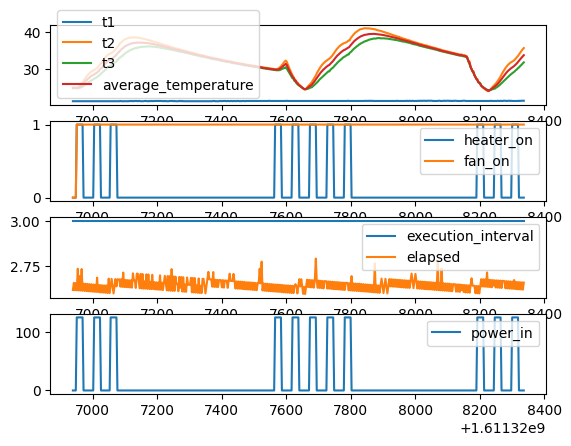

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)

ax1.plot(data["time"], data["t1"], label="t1")
ax1.plot(data["time"], data["t2"], label="t2")
ax1.plot(data["time"], data["t3"], label="t3")
ax1.plot(data["time"], data["average_temperature"], label="average_temperature")
ax1.legend()

ax2.plot(data["time"], data["heater_on"], label="heater_on")
ax2.plot(data["time"], data["fan_on"], label="fan_on")
ax2.legend()

ax3.plot(data["time"], data["execution_interval"], label="execution_interval")
ax3.plot(data["time"], data["elapsed"], label="elapsed")
ax3.legend()

ax4.plot(data["time"], data["power_in"], label="power_in")
ax4.legend()

In [5]:
events

,time,event,timestamp_ns
0,1611327598000000000,Lid Opened,2021-01-22 14:59:58
1,1611327658000000000,Lid Closed,2021-01-22 15:00:58
2,1611328159000000000,Lid Opened,2021-01-22 15:09:19
3,1611328225000000000,Lid Closed,2021-01-22 15:10:25


In [6]:
# Inputs to _plant
measurements_heater = np.array([1.0 if b else 0.0 for b in data["heater_on"]])
measurements_Troom = data["t1"].to_numpy()

# System state measurements (partial)
measurements_T = data["average_temperature"].to_numpy()

# Initial particles. Each particle represents a possible system state.
N = 100
particles = np.zeros((N, 2))
particles[:, 0] = measurements_T[0]  # Initial heater temperature
particles[:, 1] = measurements_T[0]  # Initial box temperature

weights = np.ones(N) / N  # Uniform weights

observation_noise_std = 0.1 # Comes from temperature sensor datasheet
process_noise_std = 0.3 # Can be tuned to, e.g., better detect that lid has been opened.

# Show how vectorized functions work:
der_T_heater_function(particles[:, 0], particles[:, 1], C_air_num, G_box_num, C_heater_num, G_heater_num, V_heater_num, i_heater_num, measurements_Troom[0], measurements_heater[0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
# Main simulation loop

# results

results = np.zeros((len(data['time']), 2))
uncertainty_estimate = np.zeros((len(data['time']), 2))

for step in range(len(data['time'])):
    results[step, 0] = np.mean(particles[:, 0]) # heater temperature
    results[step, 1] = np.mean(particles[:, 1]) # box temperature
    uncertainty_estimate[step] = np.std(particles[:, 0])

    dt = data['time'][step] - data['time'][step - 1] if step > 0 else 3.0
    particles[:, 0] += der_T_heater_function(particles[:, 0], particles[:, 1], C_air_num, G_box_num, C_heater_num, G_heater_num, V_heater_num, i_heater_num, measurements_Troom[step], measurements_heater[step])*dt + np.random.normal(0, process_noise_std, N)

    # note that we're using the updated heater temperature here. This is a slightly different numerical method but simple to write and doesn't affect the results much.
    particles[:, 1] += der_T_function(particles[:, 0], particles[:, 1], C_air_num, G_box_num, C_heater_num, G_heater_num, V_heater_num, i_heater_num, measurements_Troom[step], measurements_heater[step])*dt + np.random.normal(0, process_noise_std, N)

    observation = measurements_T[step]

    # Update weights based on observation likelihood
    weights = np.exp(-0.5 * ((particles[:, 1] - observation) / observation_noise_std) ** 2)
    weights += 1e-300  # Avoid zero weights, just for numerical stability
    weights /= np.sum(weights)  # Normalize: turn the weights into a probability distribution

    # Resample particles
    indices = np.random.choice(N, N, p=weights)
    particles = particles[indices, :]
    weights = np.ones(N) / N  # Reset weights


results

array([[24.906     , 24.906     ],
       [25.0033816 , 24.91096619],
       [24.95775441, 24.93190263],
       [24.91817696, 24.87158839],
       [24.84231347, 24.91583125],
       [26.36854718, 24.8881206 ],
       [27.81590591, 24.91239551],
       [29.37544062, 25.01219114],
       [30.85202846, 25.16363162],
       [32.4989426 , 25.34741487],
       [33.9503447 , 25.55107789],
       [35.35582458, 25.82787606],
       [35.50735861, 26.09374066],
       [35.4279038 , 26.40035204],
       [35.33307416, 26.66160199],
       [35.42039972, 26.941253  ],
       [35.16472652, 27.19716784],
       [34.92405282, 27.44740782],
       [35.33342574, 27.73036496],
       [35.39266738, 27.90512598],
       [35.53342734, 28.12776079],
       [35.37633202, 28.25391921],
       [35.1518504 , 28.40704236],
       [36.82487465, 28.54557739],
       [38.28745668, 28.74996369],
       [39.81113241, 28.89845727],
       [41.31593853, 29.08388685],
       [42.97608054, 29.29986168],
       [44.58255582,

In [8]:
uncertainty_estimate

array([[0.00000000e+00, 0.00000000e+00],
       [3.51570292e-01, 3.51570292e-01],
       [5.34772021e-01, 5.34772021e-01],
       [6.05654875e-01, 6.05654875e-01],
       [5.32362407e-01, 5.32362407e-01],
       [5.47311738e-01, 5.47311738e-01],
       [6.00997211e-01, 6.00997211e-01],
       [6.22165176e-01, 6.22165176e-01],
       [5.83313752e-01, 5.83313752e-01],
       [6.45831123e-01, 6.45831123e-01],
       [6.69234411e-01, 6.69234411e-01],
       [8.00802154e-01, 8.00802154e-01],
       [6.38547181e-01, 6.38547181e-01],
       [6.49925368e-01, 6.49925368e-01],
       [9.08936759e-01, 9.08936759e-01],
       [1.02684999e+00, 1.02684999e+00],
       [1.01312512e+00, 1.01312512e+00],
       [1.10973265e+00, 1.10973265e+00],
       [8.88830876e-01, 8.88830876e-01],
       [7.32209078e-01, 7.32209078e-01],
       [6.80036855e-01, 6.80036855e-01],
       [6.79380440e-01, 6.79380440e-01],
       [7.04789916e-01, 7.04789916e-01],
       [7.60508204e-01, 7.60508204e-01],
       [7.651698

In [9]:
from data_handling import plotly_incubator_data

fig = plotly_incubator_data(data,
                            compare_to={
                                "PF": {
                                    "timestamp_ns": data["timestamp_ns"],
                                    "T": results[:, 1],
                                    "T_std_dev": uncertainty_estimate[:, 1]
                                },
                            },
                            heater_T_data={
                                "PF": {
                                    "timestamp_ns": data["timestamp_ns"],
                                    "T_heater": results[:, 0],
                                    "T_heater_std_dev": uncertainty_estimate[:, 0]
                                },
                            },
                            events=events,
                            overlay_heater=True,
                            show_hr_time=True)

# Save plotly interactive plot
import plotly.io as pio
pio.write_html(fig, file="incubator_PF.html")

fig